<a href="https://colab.research.google.com/github/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/blob/master/WA_CPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn
import scipy, scipy.stats
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Import the Data**

In [2]:
#df17=pd.read_csv('./HomelessShelter/daily-shelter-occupancy-2017-csv.csv')
#df18=pd.read_csv('./HomelessShelter/daily-shelter-occupancy-2018-csv.csv')
#df19=pd.read_csv('./HomelessShelter/daily-shelter-occupancy-2019-csv.csv')
# Load files from GitHub; add year labels
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'

dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {len(df)} records from the {year} file.')

cpi_data = pd.read_csv(path + 'CPI_MONTHLY.csv', header=20, names=['date', 'CPI', 'CPI_adj', 'Static', 'CPI_TRIM', 
                                                      'CPI_MEDIAN', 'CPI_COMMON', 'ATOM', 'CPIXFET', 'CPIW'])

Loaded 38700 records from the 2017 file.
Loaded 37770 records from the 2018 file.
Loaded 39446 records from the 2019 file.


In [ ]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]


daily_shelter_occupancy.head()

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
0,2017,1,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0
1,2017,2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0
2,2017,3,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0
3,2017,4,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0
4,2017,5,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0


In [ ]:
cpi_data['year_month']=pd.to_datetime(cpi_data['date']).dt.to_period('M')
cpi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   date        305 non-null    object   
 1   CPI         305 non-null    float64  
 2   CPI_adj     305 non-null    float64  
 3   Static      305 non-null    float64  
 4   CPI_TRIM    305 non-null    float64  
 5   CPI_MEDIAN  305 non-null    float64  
 6   CPI_COMMON  305 non-null    float64  
 7   ATOM        245 non-null    float64  
 8   CPIXFET     305 non-null    float64  
 9   CPIW        305 non-null    float64  
 10  year_month  305 non-null    period[M]
dtypes: float64(9), object(1), period[M](1)
memory usage: 26.3+ KB


In [ ]:

cpi_data.head()

,date,CPI,CPI_adj,Static,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM,CPIXFET,CPIW,year_month
0,1995-01-01,86.6,86.6,0.6,1.8,1.8,1.2,NaN,2.2,1.8,1995-01
1,1995-02-01,87.0,87.0,1.9,1.9,1.8,1.2,NaN,1.8,1.8,1995-02
2,1995-03-01,87.2,87.2,2.1,2.0,1.8,1.3,NaN,2.1,1.9,1995-03
3,1995-04-01,87.5,87.4,2.5,2.1,2.0,1.3,NaN,2.1,2.0,1995-04
4,1995-05-01,87.7,87.7,2.9,2.3,2.1,1.4,NaN,2.5,2.3,1995-05


In [ ]:
shelter_data = daily_shelter_occupancy[['occupancy_date', 'occupancy']]
shelter_data['year_month'] = shelter_data['occupancy_date'].dt.to_period('M')
shelter_data.head()

,occupancy_date,occupancy,year_month
0,2017-01-01,16,2017-01
1,2017-01-01,13,2017-01
2,2017-01-01,63,2017-01
3,2017-01-01,66,2017-01
4,2017-01-01,58,2017-01


In [ ]:
cpi_data.index = cpi_data['date']
cpi_data

,date,CPI,CPI_adj,Static,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM,CPIXFET,CPIW,year_month
date,,,,,,,,,,,
1995-01-01,1995-01-01,86.6,86.6,0.6,1.8,1.8,1.2,NaN,2.2,1.8,1995-01
1995-02-01,1995-02-01,87.0,87.0,1.9,1.9,1.8,1.2,NaN,1.8,1.8,1995-02
1995-03-01,1995-03-01,87.2,87.2,2.1,2.0,1.8,1.3,NaN,2.1,1.9,1995-03
1995-04-01,1995-04-01,87.5,87.4,2.5,2.1,2.0,1.3,NaN,2.1,2.0,1995-04
1995-05-01,1995-05-01,87.7,87.7,2.9,2.3,2.1,1.4,NaN,2.5,2.3,1995-05
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,2020-01-01,136.8,137.4,2.4,2.1,2.1,1.8,1.8,1.9,2.2,2020-01
2020-02-01,2020-02-01,137.4,137.6,2.2,2.0,2.1,1.7,1.8,1.9,2.1,2020-02
2020-03-01,2020-03-01,136.6,136.3,0.9,1.8,2.0,1.7,1.6,1.7,1.5,2020-03


In [ ]:
df = shelter_data.set_index('year_month').join(cpi_data.set_index('year_month'), lsuffix='_gas', rsuffix='_oil')
#df['CPI'] = df['CPI'].interpolate(method='linear')
# Replace missing value at the beginning of the data with the first good value
#df['CPI'].fillna(df['CPI'].transform(lambda x: cpi_data['CPI'][0]), inplace=True)
df

,occupancy_date,occupancy,date,CPI,CPI_adj,Static,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM,CPIXFET,CPIW
year_month,,,,,,,,,,,,
2017-01,2017-01-01,16,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
2017-01,2017-01-01,13,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
2017-01,2017-01-01,63,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
2017-01,2017-01-01,66,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
2017-01,2017-01-01,58,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12,2019-12-31,15,2019-12-01,136.4,137.3,2.2,2.0,2.1,1.9,1.7,1.8,2.4
2019-12,2019-12-31,33,2019-12-01,136.4,137.3,2.2,2.0,2.1,1.9,1.7,1.8,2.4
2019-12,2019-12-31,20,2019-12-01,136.4,137.3,2.2,2.0,2.1,1.9,1.7,1.8,2.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 115916 entries, 2017-01 to 2019-12
Freq: M
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   occupancy_date  115916 non-null  datetime64[ns]
 1   occupancy       115916 non-null  int64         
 2   date            115916 non-null  object        
 3   CPI             115916 non-null  float64       
 4   CPI_adj         115916 non-null  float64       
 5   Static          115916 non-null  float64       
 6   CPI_TRIM        115916 non-null  float64       
 7   CPI_MEDIAN      115916 non-null  float64       
 8   CPI_COMMON      115916 non-null  float64       
 9   ATOM            115916 non-null  float64       
 10  CPIXFET         115916 non-null  float64       
 11  CPIW            115916 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 11.5+ MB


In [ ]:
df1 = shelter_data.groupby(['occupancy_date', 'year_month']).mean()
df2 = shelter_data.groupby(['year_month']).mean()

In [ ]:
df2

,occupancy
year_month,
2017-01,43.381846
2017-02,43.501689
2017-03,43.793761
2017-04,44.576493
2017-05,44.825097
2017-06,45.265470
2017-07,45.604868
2017-08,47.029096
2017-09,47.523101


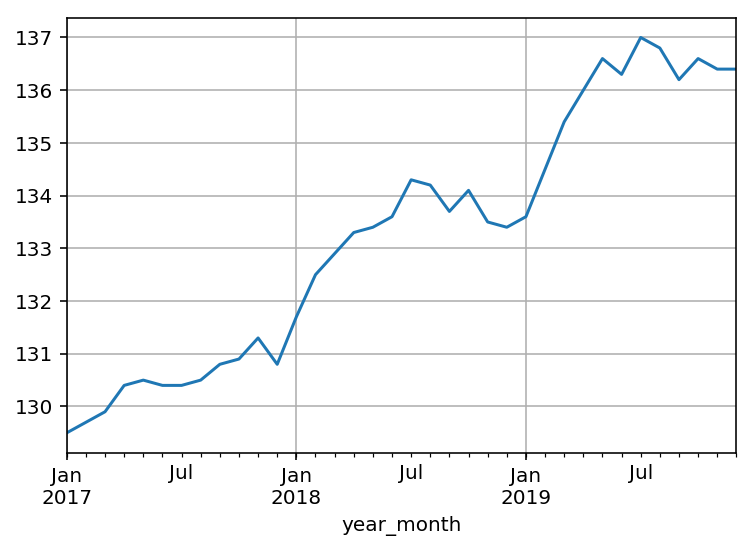

In [ ]:
plt.figure()
df.CPI.plot(grid=True)

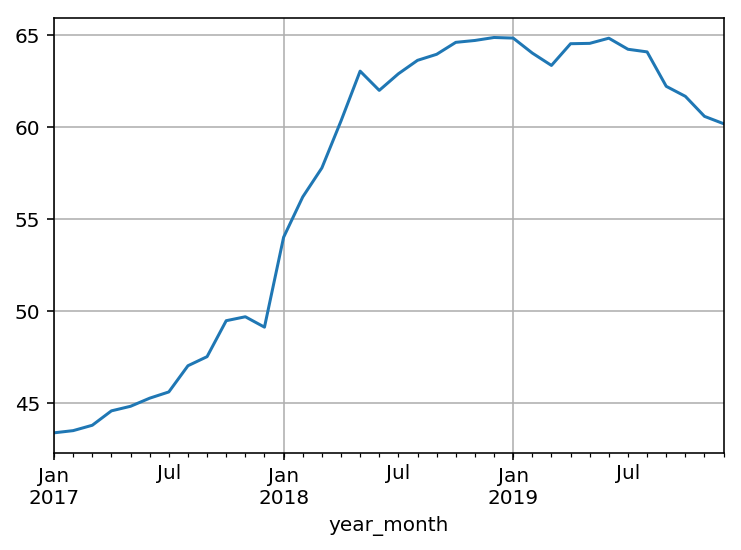

In [ ]:
df2.occupancy.plot(grid=True)

In [ ]:
df3 = df2.reset_index()
df3['occupancy']

0     43.381846
1     43.501689
2     43.793761
3     44.576493
4     44.825097
5     45.265470
6     45.604868
7     47.029096
8     47.523101
9     49.477760
10    49.692013
11    49.126854
12    54.013885
13    56.205701
14    57.782462
15    60.334603
16    63.045161
17    61.998730
18    62.901701
19    63.632078
20    63.960131
21    64.610057
22    64.712418
23    64.874178
24    64.841523
25    64.026702
26    63.354167
27    64.535560
28    64.554827
29    64.835954
30    64.233871
31    64.091348
32    62.219938
33    61.675008
34    60.586030
35    60.187036
Name: occupancy, dtype: float64

In [ ]:
cpi = df.groupby(['occupancy_date', 'year_month']).mean()
cpi = df.groupby(['year_month']).mean()
df4 = cpi.reset_index()
cpi['CPI']

year_month
2017-01    129.5
2017-02    129.7
2017-03    129.9
2017-04    130.4
2017-05    130.5
2017-06    130.4
2017-07    130.4
2017-08    130.5
2017-09    130.8
2017-10    130.9
2017-11    131.3
2017-12    130.8
2018-01    131.7
2018-02    132.5
2018-03    132.9
2018-04    133.3
2018-05    133.4
2018-06    133.6
2018-07    134.3
2018-08    134.2
2018-09    133.7
2018-10    134.1
2018-11    133.5
2018-12    133.4
2019-01    133.6
2019-02    134.5
2019-03    135.4
2019-04    136.0
2019-05    136.6
2019-06    136.3
2019-07    137.0
2019-08    136.8
2019-09    136.2
2019-10    136.6
2019-11    136.4
2019-12    136.4
Freq: M, Name: CPI, dtype: float64

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   year_month  36 non-null     period[M]
 1   occupancy   36 non-null     float64  
dtypes: float64(1), period[M](1)
memory usage: 704.0 bytes


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   year_month  36 non-null     period[M]
 1   occupancy   36 non-null     float64  
 2   CPI         36 non-null     float64  
 3   CPI_adj     36 non-null     float64  
 4   Static      36 non-null     float64  
 5   CPI_TRIM    36 non-null     float64  
 6   CPI_MEDIAN  36 non-null     float64  
 7   CPI_COMMON  36 non-null     float64  
 8   ATOM        36 non-null     float64  
 9   CPIXFET     36 non-null     float64  
 10  CPIW        36 non-null     float64  
dtypes: float64(10), period[M](1)
memory usage: 3.2 KB


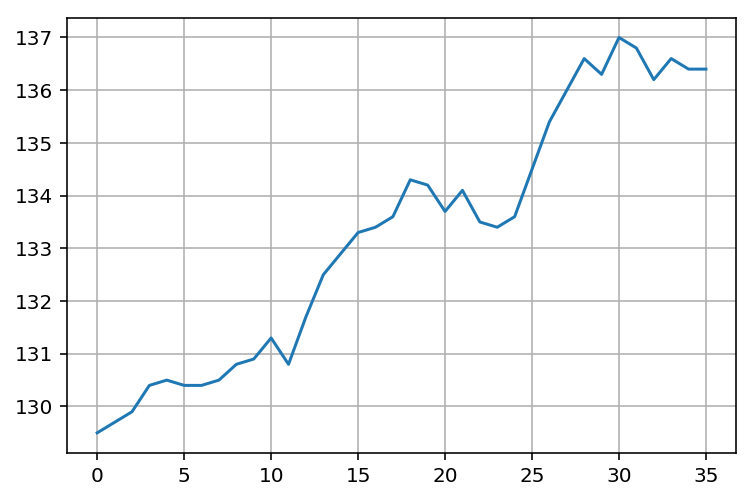

In [ ]:
plt.figure()
df4.CPI.plot(grid=True)

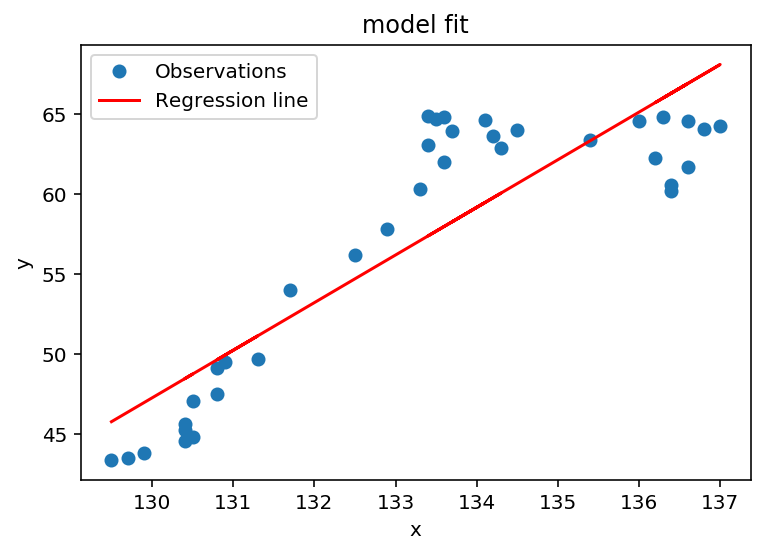

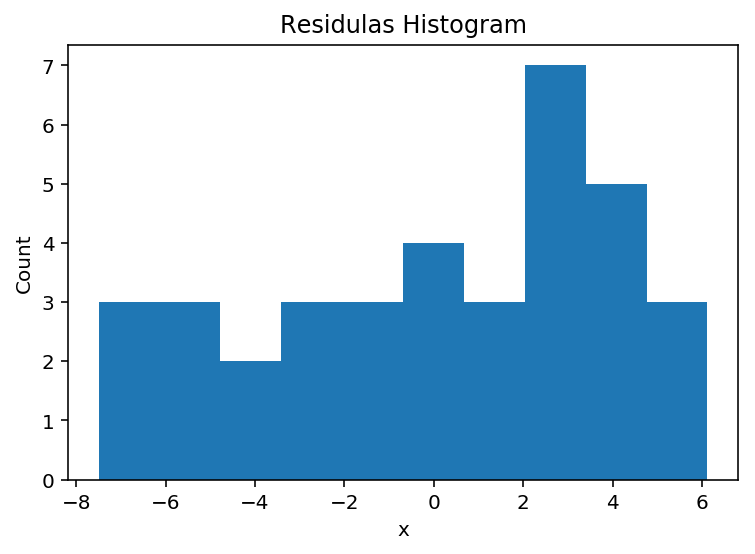

Model Residuals
count    3.600000e+01
mean    -1.598721e-14
std      3.927184e+00
min     -7.496388e+00
25%     -3.284354e+00
50%      8.799336e-01
75%      3.167316e+00
max      6.123009e+00
Name: Residuals, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     114.9
Date:                Sun, 26 Jul 2020   Prob (F-statistic):           1.91e-12
Time:                        22:32:21   Log-Likelihood:                -99.820
No. Observations:                  36   AIC:                             203.6
Df Residuals:                      34   BIC:                             206.8
Df Model:                           1                                         
Covariance Type:            nonrobust                            

In [ ]:
result = pd.concat([df4['CPI'], df3['occupancy']], axis=1, sort=False)

m = sm.ols('occupancy ~ CPI', data = result)
m = m.fit()
intercept, slope = m.params
result['y_est'] = intercept + slope * result.CPI

# Calculate the residuals
result['Residuals'] = result['y_est'] - result['occupancy']

plt.plot(result.CPI, result.occupancy, 'o', label = 'Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('model fit')

# Plot regression line
plt.plot(result.CPI, result.y_est, 'r-', label='Regression line')

# Add legend
plt.legend()
plt.show()

# We will plot the histogram of the residuals first
plt.hist(result.Residuals)

# Add axes labels
plt.xlabel('x')
plt.ylabel('Count')
plt.title('Residulas Histogram')
plt.show()

# And we will print the statistical summary of the residuals,
# i.e. (median, mean, quartiles, etc.)
print('Model Residuals')
print(result['Residuals'].describe())
print('=========================')
# Print model summary 
print(m.summary())

